<a href="https://colab.research.google.com/github/AmnaAkram987/AmnaAkram987/blob/main/Project_00.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture --no-stderr
%pip install -U langgraph langsmith langchain_google_genai
%pip install -U tavily-python langchain_community

In [ ]:
%%capture --no-stderr
%pip install -U langgraph langgraph-checkpoint-postgres psycopg psycopg-pool langchain_google_genai

In [ ]:
from google.colab import userdata
GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')

In [ ]:
import os
from google.colab import userdata
os.environ["LANGCHAIN_API_KEY"]=userdata.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"]="true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

gemini_api_key = userdata.get("GEMINI_API_KEY")
os.environ["TAVILY_API_KEY"] = userdata.get("TAVILY_API_KEY")

In [ ]:
from  langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model= "gemini-1.5-flash",
    max_tries=3,
    api_key=gemini_api_key
)

In [ ]:
llm.invoke("hi")

ChatGoogleGenerativeAIError: Invalid argument provided to Gemini: 400 API key expired. Please renew the API key. [reason: "API_KEY_INVALID"
domain: "googleapis.com"
metadata {
  key: "service"
  value: "generativelanguage.googleapis.com"
}
, locale: "en-US"
message: "API key expired. Please renew the API key."
]

**Chatbot Specifications and Features**:

- Powered by Gemini-1.5-Flash for advanced language understanding.  
- Uses `TypedDict` and reducer for dynamic state management.  
- Integrates TavilySearchResults for real-time web search.  
- Includes MemorySaver for maintaining thread context.  
- Focused on CS subjects (OOPS, DBMS, Networking, etc.) with resource recommendations (MDN, W3Schools, LeetCode).  
- Built with `StateGraph` for modular, scalable design.  

In [ ]:
from google.colab import userdata
DB_URI = userdata.get('DB_URL')

In [ ]:
from psycopg_pool import ConnectionPool
from langgraph.checkpoint.postgres import PostgresSaver

# Connection pool for efficient database access
connection_kwargs = {"autocommit": True, "prepare_threshold": 0}

# Create a persistent connection pool
pool = ConnectionPool(conninfo=DB_URI, max_size=20, kwargs=connection_kwargs)

# Initialize PostgresSaver checkpointer
checkpointer = PostgresSaver(pool)
checkpointer.setup()  # Ensure database tables are set up

In [ ]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import START , END , StateGraph
from langgraph.graph.message  import add_messages
from langchain_core.messages import BaseMessage
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.prebuilt import ToolNode ,tools_condition
from  langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.prompts import ChatPromptTemplate

#reducer
class State(TypedDict):
  messages:Annotated[list[BaseMessage],add_messages]


In [ ]:

# llm
llm = ChatGoogleGenerativeAI(
    model= "gemini-1.5-flash",
    max_retries=3,
    api_key=gemini_api_key
)


#Tavily web search tool
tool=TavilySearchResults(max_results=3)
tools=[tool]

llm_with_tool = llm.bind_tools(tools)

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", "This chatbot assists students in learning core CS subjects like OOPS, DBMS, Programming, "
                   "Networking, DSA, ICT, and AI. It provides clear explnation and  suggests resources  and focuses on both theory and practice."
                    "Also call a tool when needed  for web search for real world query or resources It will only answer CS-related queries."
                    " Search the web for the latest resources, tools, and trends when relevant."),
        ("placeholder", "{messages}"),
        ("user", "Remember, You are an expert engineer and mentor who help students to build strong foundation."),
    ]
)

def chatbot(state:State):
  #modified_prompt = prompt.format( messages = state["messages"])
  #return {"messages":[llm_with_tool.invoke(modified_prompt)]}
  return {"messages": [llm_with_tool.invoke(state["messages"])]}

#Introducing memory in while  thread is same
memory = MemorySaver()

#config
config={"configurable" :{"thread_id": "1" } }


# Build Graph
graph_builder = StateGraph(State)
graph_builder.add_node("chatbot",chatbot) #added node1

tool_node=ToolNode(tools=[tool])
graph_builder.add_node("tools",tool_node) #added node2

graph_builder.add_conditional_edges(
    "chatbot" , tools_condition ,
)

graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")

graph = graph_builder.compile(checkpointer=memory ,  interrupt_before=["tools"],)


#Compile graph
#graph = graph_builder.compile(checkpointer= memory)

user_input = "Search for latest AI news"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()



================================ Human Message =================================

Search for latest AI news
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (31433984-1822-4d7f-b4c9-7d2a8f6b84c2)
 Call ID: 31433984-1822-4d7f-b4c9-7d2a8f6b84c2
  Args:
    query: latest AI news


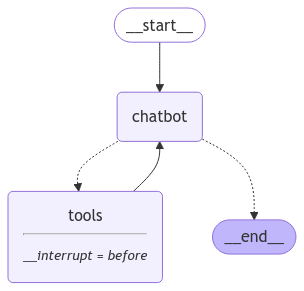

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
user_input = "Search for the top coding practices for competitive programming."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Search for the top coding practices for competitive programming.
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (ff76fbd6-bfca-498d-8932-cc06e2c1853f)
 Call ID: ff76fbd6-bfca-498d-8932-cc06e2c1853f
  Args:
    query: top coding practices for competitive programming


In [ ]:
snapshot = graph.get_state(config)
snapshot.next

('tools',)

In [ ]:
thread = {"configurable": {"thread_id": "2"}}

# Run the graph until the first interruption
for event in graph.stream(user_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

# Get user feedback
user_approval = input("Do you want to call the tool? (yes/no): ")

# Check approval
if user_approval.lower() == "yes":

    # If approved, continue the graph execution
    for event in graph.stream(None, thread, stream_mode="values"):
        event['messages'][-1].pretty_print()

else:
    print("Operation cancelled by user.")

In [ ]:
# `None` will append nothing new to the current state, letting it resume as if it had never been interrupted
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()


================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (ff76fbd6-bfca-498d-8932-cc06e2c1853f)
 Call ID: ff76fbd6-bfca-498d-8932-cc06e2c1853f
  Args:
    query: top coding practices for competitive programming
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.quora.com/What-is-the-best-strategy-to-improve-my-skills-in-competitive-programming-in-C++-in-2-3-months", "content": "So yes, the best strategy to improve your competitive programming skill is to practice a lot, but you must solve gradually harder problems, not just the easy ones. Structured preparation for problem-solving (DSA) is crucial, rather than practicing problems randomly on platforms like LeetCode or GeeksforGeeks 📚. o First 4 Months: Focus on coding interviews by teaching DSA, problem-solving techniques, and practicing company-specific questions. Devoting a few hours e

In [ ]:
user_input = "Summarize the conversation till now"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Summarize the conversation till now
================================== Ai Message ==================================

Our conversation began with you asking me to search for the latest AI news using the available `default_api`.  Then, you asked me to search for top coding practices for competitive programming, again using the same API.  I provided summaries of the search results in both cases. Finally, you asked me to summarize the conversation, which I am doing now.
